In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas
import os, shutil, time, pdb, random, pickle
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [91]:
from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from elbo import *

In [5]:
# from shapely.geometry import box, mapping
# import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set_theme()
pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rc_file_defaults()

In [6]:
from plum import dispatch
from varz.torch import Vars
import torch.nn as nn
from stheno.torch import B, GP, EQ, Normal, Measure
from matrix import Diagonal

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [7]:
from gp_mlp import *

In [8]:
# # Import Beas and Sutlej shapefiles
# beas_shp = '/Users/marron31/Google Drive/PhD/gis/exports/beas_watershed.shp'
# sutlej_shp = '/Users/marron31/Google Drive/PhD/gis/exports/sutlej_watershed.shp'

# beas = geopandas.read_file(beas_shp)
# sutlej = geopandas.read_file(sutlej_shp)

# catchments = beas.append(sutlej)

In [9]:
# Let all of Stheno run on that device.
B.device(device).__enter__()
B.epsilon = 1e-1  # Needs to be relatively high for `float32`s
# B.epsilon is the default value for the diagonal jitter of the matrix

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/lab/generic.py:296: DeprecationWarning: The use of `device` to change the active device is deprecated. Please use `on_device` instead.
  warnings.warn(


In [10]:
# Parameters
start="1900-01-01"
end="2020-12-31"

TRAIN_PATH = "../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl"
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"
# TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'

In [11]:
"""

df = pd.read_pickle('../../data/idaweb/observations_enriched_WRF.pkl')
# df.rename(columns={"stn":"Station"}, inplace=True)

# Calculate Day of Year
df['DOY'] = df['date'].dt.dayofyear

# Apply cosine and sine transformations
# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range
df['doy_sin'] = np.cos(2 * np.pi * df['DOY'] / 365.25)
df['doy_cos'] = np.sin(2 * np.pi * df['DOY'] / 365.25)

df.rename(columns={'Elevation [m]':'Z'},inplace=True)

df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Z'] = pd.to_numeric(df['Z'], errors='coerce')
# df = df.dropna()


df = df[['Station', 
# 'time', 'rka150d0', 'qrka150d0', 'mrka150d0', 'date', 'rre150d0', 'qrre150d0', 'mrre150d0', 'rka150d0_flag', 'rre150d0_flag',
   'month', 'year', 'Prec', 
#     'Name', 'Data source', 'Longitude/Latitude', 'Coordinates [km]', 
    'Z', 
#     'Lon', 'Lat', 
    'X', 'Y', 'Date',
         'doy_sin','doy_cos',
   'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN','T2', 'T2MAX']]

df = df.dropna()

df = df.drop_duplicates(subset=['X','Y','Z','RAIN','doy_sin', 'doy_cos','year'])

df.to_pickle('../../data/idaweb/observations_enriched_WRF_reduced.pkl')

"""

'\n\ndf = pd.read_pickle(\'../../data/idaweb/observations_enriched_WRF.pkl\')\n# df.rename(columns={"stn":"Station"}, inplace=True)\n\n# Calculate Day of Year\ndf[\'DOY\'] = df[\'date\'].dt.dayofyear\n\n# Apply cosine and sine transformations\n# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range\ndf[\'doy_sin\'] = np.cos(2 * np.pi * df[\'DOY\'] / 365.25)\ndf[\'doy_cos\'] = np.sin(2 * np.pi * df[\'DOY\'] / 365.25)\n\ndf.rename(columns={\'Elevation [m]\':\'Z\'},inplace=True)\n\ndf[\'X\'] = pd.to_numeric(df[\'X\'], errors=\'coerce\')\ndf[\'Y\'] = pd.to_numeric(df[\'Y\'], errors=\'coerce\')\ndf[\'Z\'] = pd.to_numeric(df[\'Z\'], errors=\'coerce\')\n# df = df.dropna()\n\n\ndf = df[[\'Station\', \n# \'time\', \'rka150d0\', \'qrka150d0\', \'mrka150d0\', \'date\', \'rre150d0\', \'qrre150d0\', \'mrre150d0\', \'rka150d0_flag\', \'rre150d0_flag\',\n   \'month\', \'year\', \'Prec\', \n#     \'Name\', \'Data source\', \'Longitude/Latitude\', \'Coordinates [km]\', \n    \'Z\', \

In [12]:
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced.pkl'

In [13]:
predictant = ['Prec']
predictors = [
              #'Date',
              #'Station',
              #'Prec',
              #'Corrected Station Name', 
              'X', 'Y',
              #'Altitude (m)', 
#               'Z', 
#               'RAIN', #'wrf_bc_prcp', 
              #'elev_hr', 
              #'aspect','slope', 
              #'doy', 
              'doy_sin', 'doy_cos', 
              'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN',
              'T2', 'T2MAX'
              #'wrf_prcp_-1', 'wrf_prcp_-2','wrf_prcp_1', 'wrf_prcp_2', 
              #'Basin', 'lon', 'lat', 
#               'era5_u', 'era5_v',
              #'era5_u_-2', 'era5_u_-1', 'era5_u_1', 'era5_u_2', 
              #'era5_v_-2', 'era5_v_-1', 'era5_v_1', 'era5_v_2'
             ]

In [14]:
# root_folder = '../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl'

In [15]:
TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'

In [16]:
stations_langtang = ['Tipping Bucket Lama Hotel', 
                    'Tipping Bucket Langtang',
                   'Tipping Bucket Kyanjing', 
#                    'Tipping Bucket Numthang old',
#                    'Tipping Bucket Jathang', 
#                     'Pluviometer Yala', 
#                     'AWS Kyangjing',
#                    'AWS Yala BC', 
                    'Tipping Bucket Ganja La 3',
                   'Tipping Bucket Ganja La 2',
                   'Tipping Bucket Langshisha Glacier (next to Pluviometer)',
                   'Tipping Bucket Ganja La 1',
                    'Tipping Bucket Langshisha BC',
                   'Tipping Bucket Shalbachum',
#                    'Pluviometer Langshisha Glacier (off-glacier)',
                   'Pluviometer GanjaLa', 'Pluviometer Morimoto']

exclusion_list = ['Tipping Bucket Numthang old', 'Tipping Bucket Jathang',
                   'Pluviometer Langshisha Glacier (off-glacier)', 'Pluviometer Yala',
                   'AWS Kyangjing', 'AWS Yala BC']

[s not in exclusion_list for s in stations_langtang]

sublist = ['AWS Kyangjing', 'AWS Yala BC', 'Pluviometer Yala']

In [17]:
# Initially used to create split but then manually setting stations because there is some issue with stations missing after data preparation process
# pick 10% random stations for validation, 10% for testing and the rest for training
stations = list(pd.read_pickle(TRAIN_PATH).Station.unique())
random.shuffle(stations)
val_stations = stations[:int(len(stations)*0.1)]
test_stations = stations[int(len(stations)*0.1):int(len(stations)*0.2)]
train_stations = stations[int(len(stations)*0.2):]

In [18]:
train_stations = ['ABO', 'AHO', 'AIR', 'ALV', 'APT', 'ARO', 'AUB', 'AVA', 'AVB', 'BAC', 'BAL', 'BEA', 'BEC', 'BEGTH', 'BEGWA', 'BEH', 'BEHAK', 'BEKSE', 'BERIF', 'BES', 'BEV', 'BIN', 'BIV', 'BLA', 'BRA', 'BRW', 'BSP', 'BSW', 'CAV', 'CDF', 'CHA', 'CHB', 'CHD', 'CHM', 'CHW', 'CIM', 'COV', 'CTA', 'CTO', 'CUE', 'DAV', 'DIB', 'DIS', 'DLBAL', 'DLFEB', 'DLZUG', 'DMA', 'DOL', 'EIT', 'ENG', 'ERN', 'EVL', 'EVO', 'FIL', 'FIO', 'FIT', 'FLI', 'FRE', 'GEN', 'GOA', 'GRC', 'GRH', 'GSB', 'GSG', 'GST', 'GTT', 'GWA', 'HER', 'HIR', 'HOE', 'INF', 'IYDEO', 'IYDEU', 'IYMMR', 'IYMUW', 'IYPEN', 'IYPFE', 'IYPFI', 'IYPLI', 'IYPRU', 'IYREI', 'IYRID', 'IYROT', 'IYSMG', 'IYSMT', 'IYSUL', 'IYSUM', 'IYSVP', 'IYSWA', 'IYTER', 'IYTOB', 'IYULT', 'IYVAA', 'IYVAL', 'IYWEL', 'IYWOL', 'KLA', 'KRO', 'KSE', 'LBA', 'LEH', 'LEU', 'LOC', 'LOE', 'MAL', 'MAT', 'MAU', 'MLS', 'MOD', 'MSO', 'MST', 'MTE', 'MUE', 'MUS', 'MVE', 'NABCHA', 'NABDAV', 'NAP', 'NEB', 'OBI', 'OBW', 'PDM', 'PIG', 'PIL', 'PLF', 'PON', 'PSB', 'PUD', 'REC', 'ROB', 'ROE', 'ROG', 'RUM', 'SAB', 'SAE', 'SAF', 'SAM', 'SAN', 'SAP', 'SAS', 'SBA', 'SBE', 'SCU', 'SDO', 'SED', 'SEP', 'SGD', 'SIA', 'SIM', 'SLFAM2', 'SLFEM2', 'SLFFIS', 'SLFGL2', 'SLFMEI', 'SLFOBM', 'SLFSA3', 'SLFSC2', 'SLFSC3', 'SLFTU2', 'SLFUR2', 'SLFURS', 'SNE', 'SOG', 'SRL', 'STP', 'SVG', 'SWA', 'TIBED', 'TIBIA', 'TICOL', 'TIFUS', 'TIOLI', 'TST', 'UNS', 'URB', 'VDLSP', 'VDSEP', 'VEL', 'VIO', 'VRI', 'VSANZ', 'VSARO', 'VSBRI', 'VSCHY', 'VSDUR', 'VSEMO', 'VSFIN', 'VSGDX', 'VSJEI', 'VSMAT', 'VSSAB', 'VSSTA', 'VST', 'VSVER', 'WAW', 'WET', 'ZER', 'ZEV', 'ZNZ']
val_stations = ['ANT', 'BEHAB', 'BIO', 'BOS', 'BRL', 'BUF', 'ELO', 'FIE', 'GRY', 'GUE', 'IYHIN', 'IYTAU', 'KAS', 'LAT', 'LBG', 'MEB', 'RIE', 'SLFSH2', 'SLFSP2', 'SMM', 'SMZ', 'TICVM', 'VAB', 'VSMOI', 'VSTSN']
len(train_stations), len(val_stations)

(199, 25)

In [20]:
ds_dataset = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=train_stations)
ds_dataset_val = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=val_stations)
# ds_dataset_test = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=test_stations)
# ds_dataset_map = UpperIndusDataset(TEST_PATH, start, end, predictant, predictors, stations=test_stations)

train_mean = ds_dataset.mean
train_var = ds_dataset.var

/users/marron31/repos/upper-indus-prec-bc/preprocessing_utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[series][df[series] < 0] = 0
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version ins

In [22]:
train_dataloader = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=ds_dataset_val, batch_size=16, shuffle=True)
# dataloader_test = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
# test_dataloader = dataloader_test

In [24]:
ds_dataset_map = MapDataset(TEST_PATH, predictors, train_mean, train_var)
dataloader_map = DataLoader(dataset=ds_dataset_map, batch_size=1, shuffle=False)

# MODELS

In [26]:
model = MLP(in_channels= len(predictors)-1, 
            hidden_channels=[10,10], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 293


In [27]:
MLP = MLP(in_channels= len(predictors), 
            hidden_channels=[10,10], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in MLP.parameters())}')

Number of parameters: 303


In [28]:
model.to(device)
MLP.to(device);

In [30]:
def reset_weights(m):
    '''
    This function resets model weights randomly following the original initialization method.
    Works for simple architectures and commonly used layers.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # If the layer has the method `reset_parameters`, it will be called
            layer.reset_parameters()

### MLP

In [36]:
MLP.apply(reset_weights);

In [37]:
train_losses = []
val_losses = []
test_losses = []

train_loader = train_dataloader
valid_loader = val_dataloader
# test_loader = dataloader

epochs = 30

optimizer = torch.optim.Adam(MLP.parameters(), lr=0.0001)

for epoch in range(epochs):
    
    epoch_train_losses, epoch_val_losses = [], []
    
    MLP.train()
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
        labels = labels.float().to(device) # [batch_size, num_stations]
        
        inputs = inputs.permute([0,2,1])
        batch_size = inputs.shape[0]
        
        optimizer.zero_grad()
        
        outputs = MLP(inputs)

        loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum')/batch_size 
        # print('train: ', epoch, i, loss.item())
        
        if loss.item() != 0: 
            
            loss.backward()
            
            for param in optimizer.param_groups[0]['params']:
                nn.utils.clip_grad_value_(param, 1) # Bit of regularisation

            optimizer.step()
        
        epoch_train_losses.append(loss.item())
        
        #train_loss, val_loss, test_loss = train_epoch(MLP, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch, device=device, permute=True)

    model.eval()
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(val_dataloader):

            inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
            labels = labels.float().to(device) # [batch_size, num_stations]
        
            inputs = inputs.permute([0,2,1])
            batch_size = inputs.shape[0]
            
            outputs = MLP(inputs)
            
#             pdb.set_trace()
            
#             assert inputs.isnan().sum() == 0
#             assert outputs.isnan().sum() == 0
#             assert labels.isnan().sum() == 0

#             # device = labels.device
#             logp = torch.zeros_like(labels, device=device)
    
#             b_mask = labels == 0 # shape (b, n_samples, k)
#             g_mask = labels > 0

#             # shape of outputs: (b, num_stations, n_samples, num_output_dims)
   
#             pi = outputs[...,0] # shape (b, num_stations, n_samples)
#             alpha = outputs[...,1] # shape (b, num_stations, n_samples)
#             beta = outputs[...,2] # shape (b, num_stations, n_samples)

#             # Computing log probabilities for gamma distribution where obs > 0
#             gamma_dist = Gamma(concentration=alpha[g_mask], rate=beta[g_mask])
#             logp[g_mask] = torch.log((1 - pi[g_mask])) + gamma_dist.log_prob(labels[g_mask])
    
#             # Computing log probabilities for Bernoulli distribution where obs == 0
#             logp[b_mask] = torch.log(pi[b_mask])

#             if mask is not None:
#                 logp = logp * mask

            loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum')/batch_size
            # print('val: ', epoch, i, loss.item())

            epoch_val_losses.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_losses)/len(train_stations) 
    epoch_val_loss = np.mean(epoch_val_losses)/len(val_stations) #, np.mean(test_losses)
    
    print(f'epoch : {epoch+1}, train loss : {np.mean(epoch_train_loss):.4f} , valid loss : {np.mean(epoch_val_loss):.4f}')
   
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
#     test_losses.append(test_loss)

epoch : 1, train loss : 2.1587 , valid loss : 1.4524
epoch : 2, train loss : 1.5759 , valid loss : 1.2909
epoch : 3, train loss : 1.4652 , valid loss : 1.2218
epoch : 4, train loss : 1.3957 , valid loss : 1.1481
epoch : 5, train loss : 1.3301 , valid loss : 1.0843
epoch : 6, train loss : 1.2891 , valid loss : 1.0506
epoch : 7, train loss : 1.2677 , valid loss : 1.0293
epoch : 8, train loss : 1.2541 , valid loss : 1.0148
epoch : 9, train loss : 1.2456 , valid loss : 1.0047
epoch : 10, train loss : 1.2387 , valid loss : 0.9982
epoch : 11, train loss : 1.2328 , valid loss : 0.9932
epoch : 12, train loss : 1.2306 , valid loss : 0.9885
epoch : 13, train loss : 1.2266 , valid loss : 0.9855
epoch : 14, train loss : 1.2253 , valid loss : 0.9835
epoch : 15, train loss : 1.2223 , valid loss : 0.9818
epoch : 16, train loss : 1.2208 , valid loss : 0.9776
epoch : 17, train loss : 1.2193 , valid loss : 0.9766
epoch : 18, train loss : 1.2173 , valid loss : 0.9744
epoch : 19, train loss : 1.2148 , val

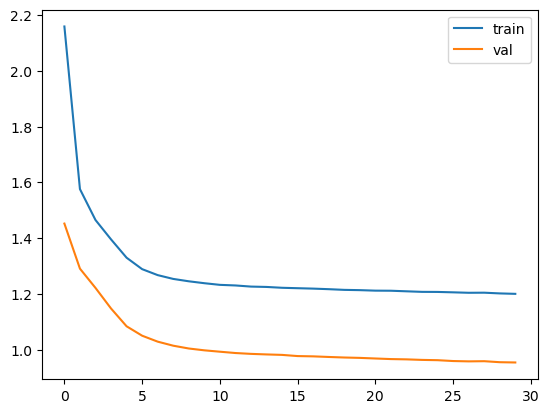

In [40]:
plt.plot(np.array(train_losses), label='train')
plt.plot(np.array(val_losses), label='val')
plt.legend()
plt.show()

### GP-MLP

In [32]:
model.apply(reset_weights);

In [85]:
print_progress = True
plot_x_ind = True
validate_flag = True
f_marginal_flag = False
mc_samples = 5

In [34]:
# arr, _ = UpperIndusGridDataset(root_folder, train_mean, train_var).__getitem__(10)

# x_min = arr[0,:].min()
# x_max = arr[0,:].max() 
# y_min = arr[1,:].min()
# y_max = arr[1,:].max()

In [35]:
st = ds_dataset.st
x_ind_stations = st.groupby('Station').mean()[['X','Y']].values
x_ind_stations.shape

(199, 2)

In [86]:
print_gpu_usage()
torch.cuda.empty_cache()
print(f'Clear empty cache')
print_gpu_usage()

Memory Allocated: 8.64598784 GB
Memory Cached (Reserved): 8.84998144 GB
Clear empty cache
Memory Allocated: 8.64598784 GB
Memory Cached (Reserved): 8.84998144 GB


In [105]:
# Number of points for inducing points grid
# x_points = 30
# y_points = 30

#  Grid of equally spaced points covering the spatial extent for which station data is available
# grid = np.meshgrid(np.linspace(st['X'].min(),st['X'].max(),x_points),np.linspace(st['Y'].min(),st['Y'].max(),y_points))
# grid = np.meshgrid(np.linspace(x_min,x_max,x_points),np.linspace(y_min,y_max,y_points))

# Make grid into a tensor
# grid = torch.tensor(grid, dtype=torch.float32).flatten(start_dim=1).permute(1,0)

# x_ind = grid.clone().detach().requires_grad_(True)
# num_ind_points = x_points * y_points
    
# Inducing points are points in the station
x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False).to(device)
num_ind_points = len(x_ind)

n = len(st)

train_loss, train_loglik, train_kl, train_nll = [], [], [], []
val_loss, val_loglik, val_kl, val_nll = [], [], [], []
test_loss, test_loglik, test_kl, test_nll  = [], [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch, train_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch, val_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(),RunningAverage()

# model.train()
# prior = Measure()

with Measure() as prior:
    f1 = GP(EQ().stretch(0.5))
    #f2 = GP(EQ().stretch(2))
    #f3 = GP(EQ().stretch(0.5))
    f = f1 #+ f2 + f3

# f = GP(EQ().stretch(0.5)) # f is drawn from a GP
 
q = ApproximatePosterior(num_ind_points) # q is the approximate posterior

# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[x_ind], lr=10e-3)
optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters()), lr=10e-5)

In [114]:
torch.save(q.state_dict(), 'q_state.pth')
torch.save(model.state_dict(), 'model_state.pth')
torch.save(optimizer.state_dict(), 'optimizer_state.pth')

In [115]:
q.load_state_dict(torch.load('q_state.pth'))
optimizer.load_state_dict(torch.load('optimizer_state.pth'))
model.load_state_dict(torch.load('model_state.pth'))

<All keys matched successfully>

In [89]:
num_epochs = 30

for e in range(num_epochs):
    print_gpu_usage()
    # Run the function to get the GPU memory usage
#     get_gpu_memory_usage()
    torch.cuda.empty_cache()
    print(f'Clear empty cache for epoch {e}')
    print_gpu_usage()
    
    # TRAIN EPOCH
    
    model.train()
        
#     if plot_x_ind and (e % 10 == 0):
#         fig, ax = plt.subplots(figsize=(5,5))
#         ax.scatter(x_ind.detach()[:,0].cpu(),
#                    x_ind.detach()[:,1].cpu()
#                   )
#         plt.show()

    start = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()

    n = train_dataloader.dataset.n
    
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
#         inputs = torch.nan_to_num(inputs)
#         labels = torch.nan_to_num(labels)
#         masks - 

        # inputs [batch_size, num_predictors, num_stations]
        # labels [batch_size, num_stations ]

        inputs = inputs.to(device)
        labels = labels.to(device)

        elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                            inducing_points=True, backward=True, f_marginal=f_marginal_flag, n_samples=mc_samples-3)

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item())
        train_kl_batch.update(kl.item())
        train_nll_batch.update(nll.item()/num_points.item())

    elapsed = time.time() - start

    if print_progress:
        print(f'Train epoch  {e}: -elbo: {train_loss_batch.avg:.3f} | kl: {train_kl_batch.avg:.3f} | -recon: {train_loglik_batch.avg:.3f} | nll: {train_nll_batch.avg:.3f} -- time: {elapsed:.2f}')
    
    # Add average batch loss terms to lists
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(train_loglik_batch.avg)
    train_kl.append(train_kl_batch.avg)
    train_nll.append(train_nll_batch.avg)
    
    if validate_flag:

        # VALIDATION EPOCH

        model.eval()

        n = val_dataloader.dataset.n
        
        start = time.time()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                                    inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=mc_samples*10)

            
                # Keep track of loss terms
                val_loss_batch.update(-elbo.item())
                val_loglik_batch.update(-recon.item())
                val_kl_batch.update(kl.item())
                val_nll_batch.update(nll.item()/num_points.item())

        elapsed_val = time.time() - start

        if print_progress:
            print(f'Val epoch {e}: -elbo: {val_loss_batch.avg:.3f} | kl: {val_kl_batch.avg:.3f} | -recon: {val_loglik_batch.avg:.3f} | nll: {val_nll_batch.avg:.3f} -- time: {elapsed_val:.2f}')

        # Add average batch loss terms to lists
        val_loss.append(val_loss_batch.avg)
        val_loglik.append(val_loglik_batch.avg)
        val_kl.append(val_kl_batch.avg)
        val_nll.append(val_nll_batch.avg)

Memory Allocated: 9.330869248 GB
Memory Cached (Reserved): 9.581887488 GB
Clear empty cache for epoch 0
Memory Allocated: 9.330869248 GB
Memory Cached (Reserved): 9.581887488 GB
Average values for training epoch 0: -elbo: 1.197 | kl: 23917.136 | -recon: 1.185 | nll: 1.346 -- time: 31.69
Train epoch 0: -elbo: 0.948 | kl: 22011.102 | -recon: 0.937 | nll: 1.048 -- time: 22.52
Memory Allocated: 9.833214464 GB
Memory Cached (Reserved): 10.122952704 GB
Clear empty cache for epoch 1
Memory Allocated: 9.833214464 GB
Memory Cached (Reserved): 10.1187584 GB
Average values for training epoch 1: -elbo: 1.193 | kl: 20274.297 | -recon: 1.183 | nll: 1.339 -- time: 32.90
Train epoch 1: -elbo: 0.943 | kl: 18625.109 | -recon: 0.934 | nll: 1.042 -- time: 22.83
Memory Allocated: 10.336116224 GB
Memory Cached (Reserved): 10.661920768 GB
Clear empty cache for epoch 2
Memory Allocated: 10.336116224 GB
Memory Cached (Reserved): 10.659823616 GB
Average values for training epoch 2: -elbo: 1.188 | kl: 17141.208 

[W python_variable.cpp:200] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function concrete_decref_fn)
[W python_variable.cpp:200] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function concrete_decref_fn)
[W python_variable.cpp:200] Warning: Deallocating Tensor that still has live PyObject references.  This probably happened because you took out a weak reference to Tensor and didn't call _fix_weakref() after dereferencing it.  Subsequent accesses to this tensor via the PyObject will now fail. (function concrete_decref_fn)
[W python_variable.cpp:200] War

Average values for training epoch 5: -elbo: 1.177 | kl: 10059.024 | -recon: 1.172 | nll: 1.314 -- time: 33.75
Train epoch 5: -elbo: 0.929 | kl: 9153.399 | -recon: 0.924 | nll: 1.023 -- time: 22.89
Memory Allocated: 12.241717248 GB
Memory Cached (Reserved): 12.75068416 GB
Clear empty cache for epoch 6
Memory Allocated: 12.241717248 GB
Memory Cached (Reserved): 12.702449664 GB
Average values for training epoch 6: -elbo: 1.176 | kl: 8345.477 | -recon: 1.172 | nll: 1.308 -- time: 32.61


KeyboardInterrupt: 

In [104]:
f_post
# q.state_dict(), model.state_dict()

AttributeError: 'GP' object has no attribute 'state_dict'

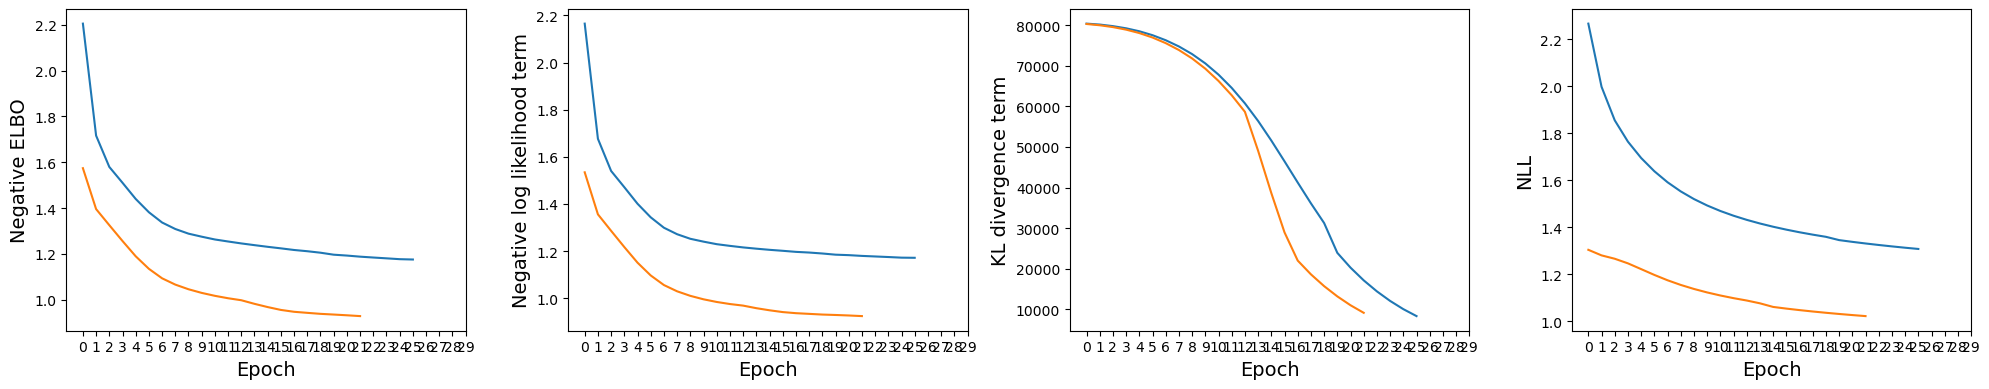

In [90]:
train_vars = [train_loss, train_loglik, train_kl, train_nll] 
validation_vars = [val_loss, val_loglik, val_kl, val_nll]

labels = ['Negative ELBO','Negative log likelihood term','KL divergence term','NLL']

fig, axes = plt.subplots(1,4, figsize=(20,4))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
    ax.plot(validation_vars[i], label='val')
#     ax.set_title(f'{labels[i]} | best: {np.min(train_vars[i]):.2f}')
    ax.set_ylabel(f'{labels[i]}', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_xticks(np.arange(0, num_epochs))
#     ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [44]:
# test_dataloader = DataLoader(dataset=UpperIndusGridDataset(root_folder, train_mean, train_var), batch_size=1, shuffle=True)

inducing_points = True

model.eval()

with torch.no_grad():
    
    for index, (inputs, aux_inputs) in enumerate(dataloader_map):
        
        inputs = inputs[:,:,:].to(device)
        aux_inputs = aux_inputs[:,:,:].to(device)
        
        b = inputs.shape[0]
        
        if index == 0:
        
            q.build_normal()

            x = inputs[0,:2,:].permute(1,0).float()
            
            inputs = inputs[:,2:,:]
            aux_inputs = aux_inputs[:,:,:10000].to(device)

            # Sample z and concatenate to inputs
            if inducing_points:
                
                #f_sample = f_post(x).sample(b).permute(1,0).unsqueeze(1)
                
                f_post = f | (f(x_ind), q.sample())
                
                if f_marginal_flag:
                    f_sample = Normal(f_post.mean(x),
                                      Diagonal(f_post.kernel.elwise(x)[:, 0])
                                      ).sample().permute(1,0).unsqueeze(1)
                else:
                    f_sample = f_post(x).sample().permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([f_sample, inputs], dim=1)
                 
            else:
                q_sample = q.sample(b).permute(1,0).unsqueeze(1)
                
                inputs = torch.cat([q_sample, inputs], dim=1)

            # Masking for missing data
            inputs = inputs.permute(0,2,1)
            aux_inputs = aux_inputs.permute(0,2,1)
 
            mask = ~torch.any(inputs.isnan(),dim=2)
            k = mask.sum()

            # Forward pass
            outputs = model(inputs[mask].float())

In [45]:
col_names = ['X','Y','wrf_prcp',
#              'doy_sin','doy_cos',
             'GPsample','pi','alpha','beta']
#col_names = ['X','Y','Z','wrf_prcp','doy_sin','doy_cos','GPsample','alpha','beta']

data = np.concatenate([aux_inputs.squeeze().cpu().numpy()[:,:2],
                       aux_inputs.squeeze().cpu().numpy()[:,9:10], # * np.sqrt(train_var[9:10]) + train_mean[9:10],
                       np.expand_dims(inputs.squeeze().cpu().numpy()[:,0], axis=1),
                       outputs.cpu().numpy()], axis=1
                       )

# pdb.set_trace()

df = pd.DataFrame(data, columns=col_names)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

gdf['uniform'] = gdf.apply(lambda x: np.random.uniform(0,1),axis=1)
#gdf['uniform'] = np.random.uniform(0,1)

gdf['sample'] = gdf.apply(sample_apply, axis=1)

gdf['uniform'] = gdf.apply(lambda x: 0.5, axis=1)
gdf['bg_median'] = gdf.apply(sample_apply, axis=1)

gdf['g_mean'] = gdf['alpha']/gdf['beta']

gdf['p'] = 1 - gdf['pi']

x_ind_plot = x_ind.detach().cpu().numpy() * np.sqrt(train_var[:2]) + train_mean[:2] 

In [46]:
st_stations = st.groupby('Station').mean()[['X','Y']] * np.sqrt(train_var[:2]) + train_mean[:2]

<AxesSubplot:>

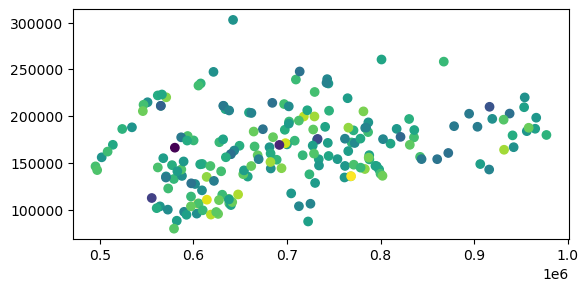

In [47]:
gdf_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_ind_plot[:,0], x_ind_plot[:,1]))

gdf_stations['q_sample'] = q.sample().detach().cpu().numpy()
gdf_stations.plot('q_sample', cmap='viridis')

# plt.plot(gdf_stations['geometry'].x, gdf_stations['q_sample'], 'o')

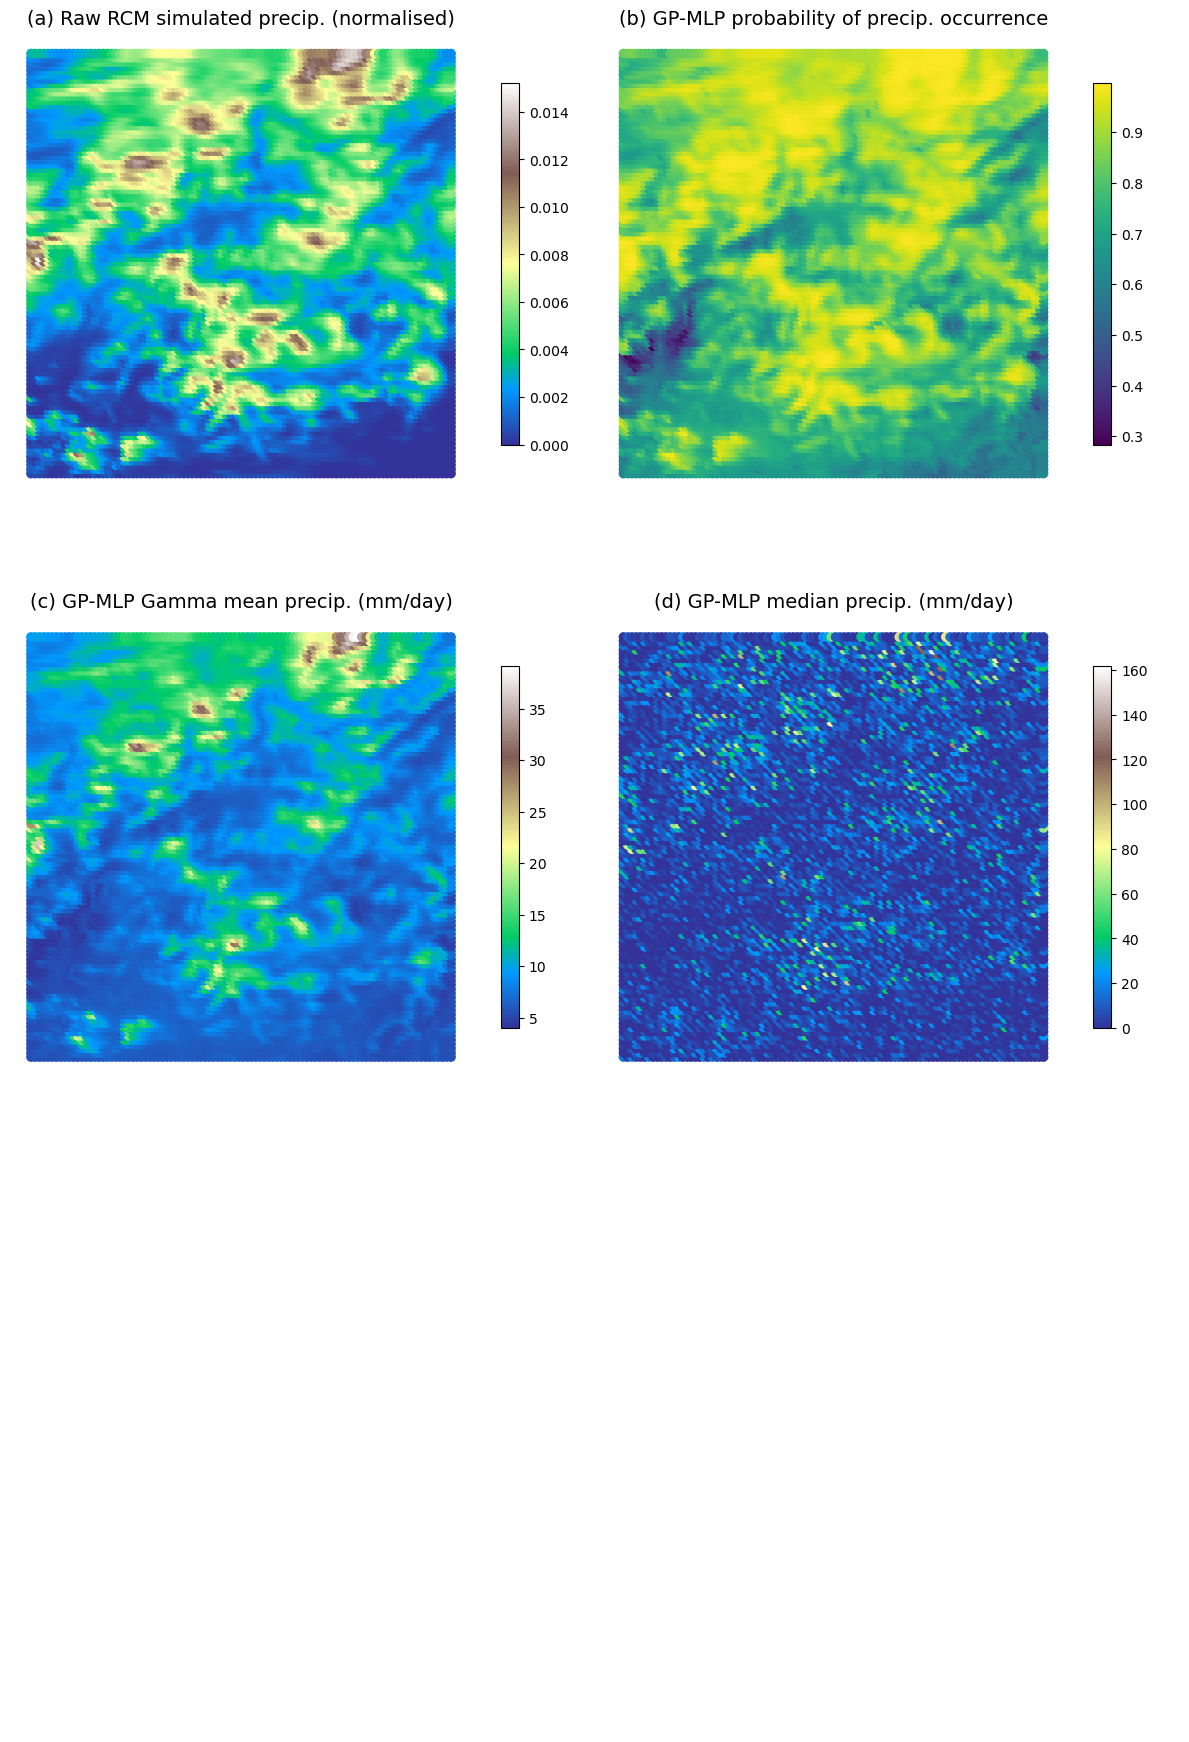

In [49]:
variables = ['wrf_prcp',
             'p',
             'g_mean',
#              'bg_median',
#              'Z',
             'sample',
#              'GPsample'
            ]

labels = ['(a) Raw RCM simulated precip. (normalised)', 
          '(b) GP-MLP probability of precip. occurrence',
#           '(c) GP-MLP Gamma mean precip. (mm/day)',
          '(d) GP-MLP median precip. (mm/day)',
#           'Elevation (m.a.s.l.)',
          '(e) BGMM sample (mm/day)', 
#           '(f) GP sample'
         ]

cmaps = ['terrain',
         'viridis',
         'terrain',
         'terrain',
#          'viridis',
#          'terrain',
#          'viridis'
        ]

fig, axes = plt.subplots(3,2,figsize=(12,18))

for idx, ax in enumerate(axes.flatten()):
    
    if idx < len(variables):
    
    #     gdf.set_crs(catchments.crs)
    #     gdf_clip = geopandas.clip(gdf, catchments)
    
        gdf.plot(variables[idx], ax=ax, legend=True, cmap=cmaps[idx], legend_kwds={'shrink': 0.6})
#         beas.plot(ax=ax, facecolor='None', edgecolor='black')
        #gdf_stations.plot(ax=ax, color='red')
        #sutlej.plot(ax=ax, facecolor='None', edgecolor='black')

        ax.set_title(labels[idx],fontsize=14)
        
        #if variables[idx]=='GPsample':
            #ax.scatter(x_ind_plot[:,0],x_ind_plot[:,1], s=4, c='r')
            #ax.scatter(st_stations['X'],st_stations['Y'], s=3, c='w')

    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_xticks([])     

plt.tight_layout()
# plt.savefig('maps2',dpi=300)